<a href="https://colab.research.google.com/github/LC1332/Suzumiya-Diffusion-Learning/blob/main/notebook/refactor_crop_face2celebHQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

简易重构和测试

In [1]:
!pip install -q mediapipe opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 38.8 MB/s eta 0:00:00


In [ ]:
!wget https://avatars.githubusercontent.com/u/5266090?v=4
!mv 5266090?v=4 example.png

In [2]:
import cv2
import mediapipe as mp

def get_detector():
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.7)
    return face_detection

__face_detector = get_detector()

def detect_face(img):
    face_detection = __face_detector
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_detection.process(img_rgb)
    faces = []
    if results.detections:
        for detection in results.detections:
            box = detection.location_data.relative_bounding_box
            x, y, w, h = box.xmin, box.ymin, box.width, box.height
            faces.append((int(x*img.shape[1]), int(y*img.shape[0]), int(w*img.shape[1]), int(h*img.shape[0])))
    return faces

In [72]:
def get_face_mesh():
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)
    return face_mesh

# mp_face_mesh = mp.solutions.face_mesh
# face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

__face_mesh = get_face_mesh()

def align_face(img, face):
    x, y, w, h = face
    h_img, w_img = img.shape[:2]
    img_rgb = cv2.cvtColor(img[y:y+h, x:x+w], cv2.COLOR_BGR2RGB)
    face_mesh = __face_mesh
    results = face_mesh.process(img_rgb)
    facial_pose = []
    if results.multi_face_landmarks:
        for landmark in results.multi_face_landmarks[0].landmark:
            facial_pose.append(((x + w * landmark.x)/w_img, (y + h * landmark.y)/h_img))
    return facial_pose


def align_face_original(img, face):
    x, y, w, h = face
    h_img, w_img = img.shape[:2]
    img_rgb = cv2.cvtColor(img[y:y+h, x:x+w], cv2.COLOR_BGR2RGB)
    face_mesh = __face_mesh
    results = face_mesh.process(img_rgb)
    facial_pose = []
    if results.multi_face_landmarks:
        for landmark in results.multi_face_landmarks[0].landmark:
            facial_pose.append(((x + w * landmark.x), (y + h * landmark.y)))
    return facial_pose

In [73]:
avg_y_on_1024 = 0.6076579708466568 * 1024
standard_dxdy = 105.64138908808019 * 1024

In [74]:
def count_pose(facial_pose):
    xs = [x for x, y in facial_pose]
    ys = [y for x, y in facial_pose]
    avg_x = sum(xs) / len(xs)
    avg_y = sum(ys) / len(ys)
    sum_dxdy = sum(abs(x - avg_x) + abs(y - avg_y) for x, y in facial_pose)
    return avg_x, avg_y, sum_dxdy

# def safe_crop(img, x0, x1, y0, y1):
#     h, w = img.shape[:2]
#     x0 = max(0, x0)
#     x1 = min(w, x1)
#     y0 = max(0, y0)
#     y1 = min(h, y1)
#     return img[y0:y1, x0:x1]

import numpy as np

def safe_crop(img, x0, x1, y0, y1, if_padding=True):
    h, w = img.shape[:2]
    # 初始化填充的边界
    pad_left = -min(0, x0)
    pad_right = max(x1 - w, 0)
    pad_top = -min(0, y0)
    pad_bottom = max(y1 - h, 0)

    # 更新坐标以保证它们在图像范围内
    x0 = max(0, x0)
    x1 = min(w, x1)
    y0 = max(0, y0)
    y1 = min(h, y1)

    cropped_img = img[y0:y1, x0:x1]

    # 如果需要填充
    if if_padding and (pad_left > 0 or pad_right > 0 or pad_top > 0 or pad_bottom > 0):
        # print("padding", pad_top, pad_bottom)
        if img.ndim == 3:  # 彩色图像
            pad_width = ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0))
        else:  # 灰度图像
            pad_width = ((pad_top, pad_bottom), (pad_left, pad_right))

        # 选择填充模式，这里使用边缘值填充
        mode = 'edge'
        cropped_img = np.pad(cropped_img, pad_width=pad_width, mode=mode)

    return cropped_img

我希望修改safe_crop这个函数，增加一个参数if_padding,默认为true

if_padding为True时，如果x0<0，小于的部分会自动复制图像最左侧的列，以此类推

In [83]:


def crop_face_to_celebHQ(img, minimal_scale_ratio=0.75):
    faces = detect_face(img)
    h, w = img.shape[:2]
    ans = []
    for face in faces:
        facial_pose = align_face_original(img, face) # 多除了img的尺寸
        # print(facial_pose)
        if facial_pose != []:
            avg_x, avg_y, sum_dxdy = count_pose(facial_pose)
            # print(avg_x, avg_y,sum_dxdy)
            scale = sum_dxdy / standard_dxdy
            # if scale < minimal_scale_ratio:
            #     continue
            x0 = round(avg_x - 511.5 * scale)
            x1 = round(avg_x + 511.5 * scale)
            y0 = round(avg_y - avg_y_on_1024 * scale )
            y1 = round(avg_y + (1024 - avg_y_on_1024)* scale )
            # print(x0, x1, y0, y1)
            ans.append(safe_crop(img, x0, x1, y0, y1, True))
    return ans

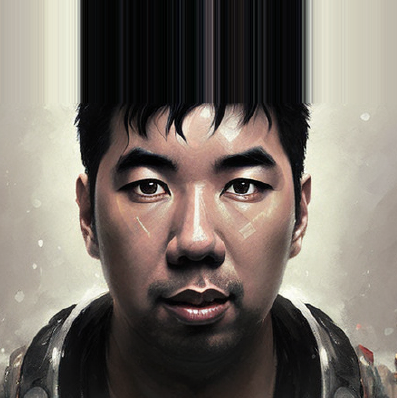

In [84]:
import cv2
from google.colab.patches import cv2_imshow
image = cv2.imread('example.png')
faces = crop_face_to_celebHQ( image, 0 )
cv2_imshow(faces[0])

----

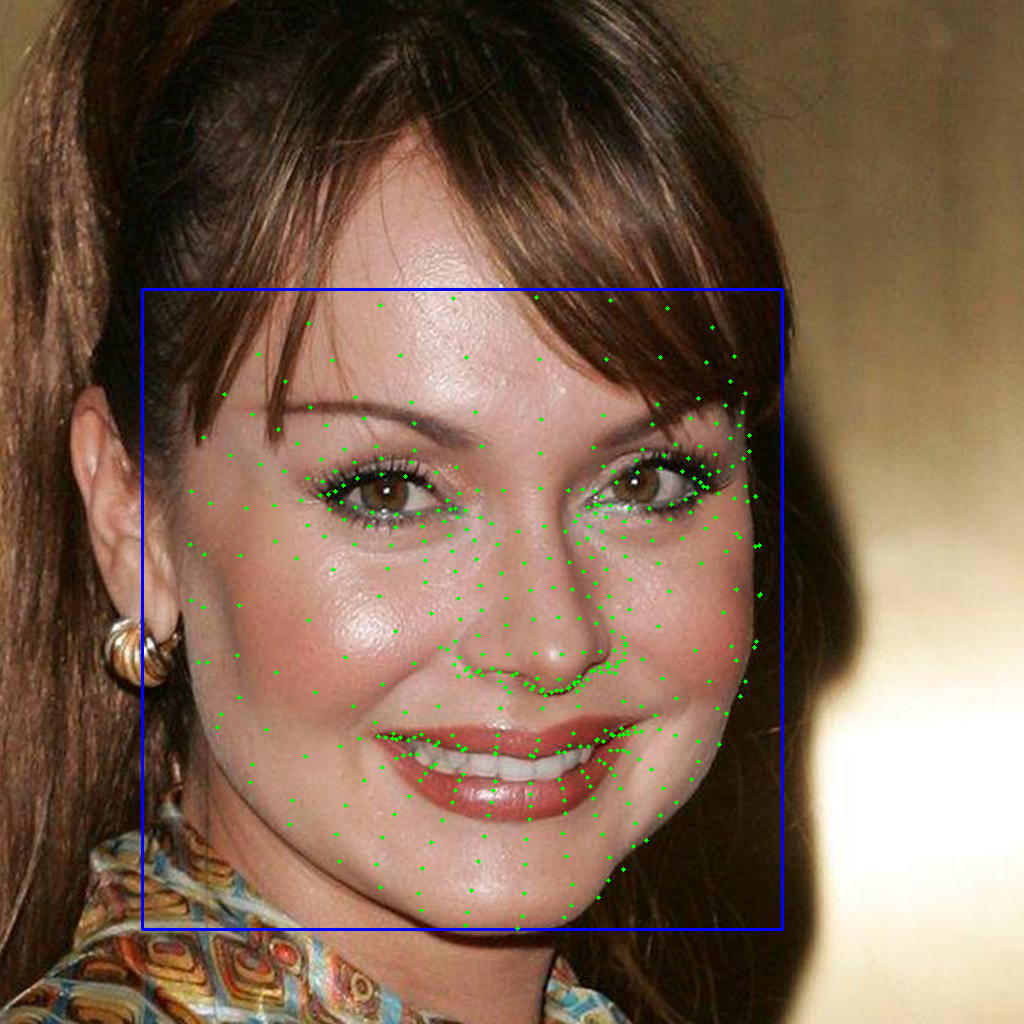

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
images_path = '/content/drive/MyDrive/CeleAHQ_subset_200/'
image = cv2.imread(images_path + '000009.jpg.jpg')

detected_faces = detect_face(image)

for face in detected_faces:
    x, y, w, h = face
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    facial_pose = align_face(image, face)
    for pose_point in facial_pose:
        x_pose, y_pose =  int(pose_point[0]*image.shape[:2][1]) , int(pose_point[1]*image.shape[:2][0])
        cv2.circle(image, (x_pose, y_pose), 2, (0, 255, 0), -1)

cv2_imshow(image)

In [ ]:
def count_pose(facial_pose):
    xs = [x for x, y in facial_pose]
    ys = [y for x, y in facial_pose]
    avg_x = sum(xs) / len(xs)
    avg_y = sum(ys) / len(ys)
    sum_dxdy = sum(abs(x - avg_x) + abs(y - avg_y) for x, y in facial_pose)
    return avg_x, avg_y, sum_dxdy

## 奇怪的报错

In [ ]:
# from google.colab.patches import cv2_imshow
# img_flip = cv2.flip(image, 1)
# faces = detect_face(img_flip)
# # num_faces += len(faces)
# print(len(faces))
# for face in faces:
#     facial_pose = align_face(img_flip, face)
#     print(facial_pose)
#     avg_x, avg_y, sum_dxdy = count_pose(facial_pose)
#     # total_avg_x += 1 - avg_x
#     # total_avg_y += avg_y
#     # total_sum_dxdy += sum_dxdy
# cv2_imshow(image)
# cv2_imshow(img_flip)
# print(detect_face(img_flip))
# print(len(align_face(img_flip, detect_face(img_flip)[0])))

In [ ]:
import os
import tqdm
total_avg_x, total_avg_y, total_sum_dxdy = 0, 0, 0
num_faces = 0

for filename in tqdm.tqdm(os.listdir(images_path)):
    img = cv2.imread(os.path.join(images_path, filename))
    faces = detect_face(img)
    # print(len(faces))
    num_faces += len(faces)
    for face in faces:
        facial_pose = align_face(img, face)
        if facial_pose != []:
          avg_x, avg_y, sum_dxdy = count_pose(facial_pose)
          total_avg_x += avg_x
          total_avg_y += avg_y
          total_sum_dxdy += sum_dxdy
        else:
          num_faces -= 1
    # print(os.path.join(images_path, filename))
    img_flip = cv2.flip(img, 1)
    faces = detect_face(img_flip)
    num_faces += len(faces)
    # print(len(faces))
    for face in faces:
        facial_pose = align_face(img_flip, face)
        if facial_pose != []:
            avg_x, avg_y, sum_dxdy = count_pose(facial_pose)
            total_avg_x += 1 - avg_x
            total_avg_y += avg_y
            total_sum_dxdy += sum_dxdy
        else:
          num_faces -= 1

avg_x_on_1024 = total_avg_x / num_faces
avg_y_on_1024 = total_avg_y / num_faces
standard_dxdy = total_sum_dxdy / num_faces

100%|██████████| 200/200 [00:11<00:00, 17.18it/s]


In [ ]:
# print()
print(avg_x_on_1024)
print(avg_y_on_1024)
print(standard_dxdy)

0.49954042499440293
0.6076579708466568
105.64138908808019


[(0.39382562965554924, 0.46389462316146696), (0.3824579808155987, 0.4029524336869514), (0.3930026506402408, 0.42287349741099356), (0.36552822891900244, 0.34318321647017364), (0.38045562139652006, 0.38391806510384585), (0.38253726056061677, 0.35958496346228647), (0.39217381694232445, 0.30038635401336106), (0.21827283639902015, 0.2997160498696209), (0.39261400019147313, 0.24656429625702386), (0.39023945299551455, 0.21947246604138498), (0.38901781453608886, 0.13035555812824445), (0.3948254084921873, 0.47342438615463117), (0.39734968484830796, 0.4814584368703339), (0.40054599374932975, 0.48563096617688223), (0.4009663522316277, 0.4906853511239062), (0.4005589977143303, 0.4997962240220723), (0.40114699720754143, 0.5109161962052806), (0.4033297890563005, 0.5215463789451393), (0.4096139116674407, 0.5341467316550373), (0.3859045146003602, 0.4126849224211894), (0.3720322789144458, 0.41250907390581626), (0.1525807469828516, 0.22751410264073044), (0.2932617946713253, 0.3176678768606274), (0.26748

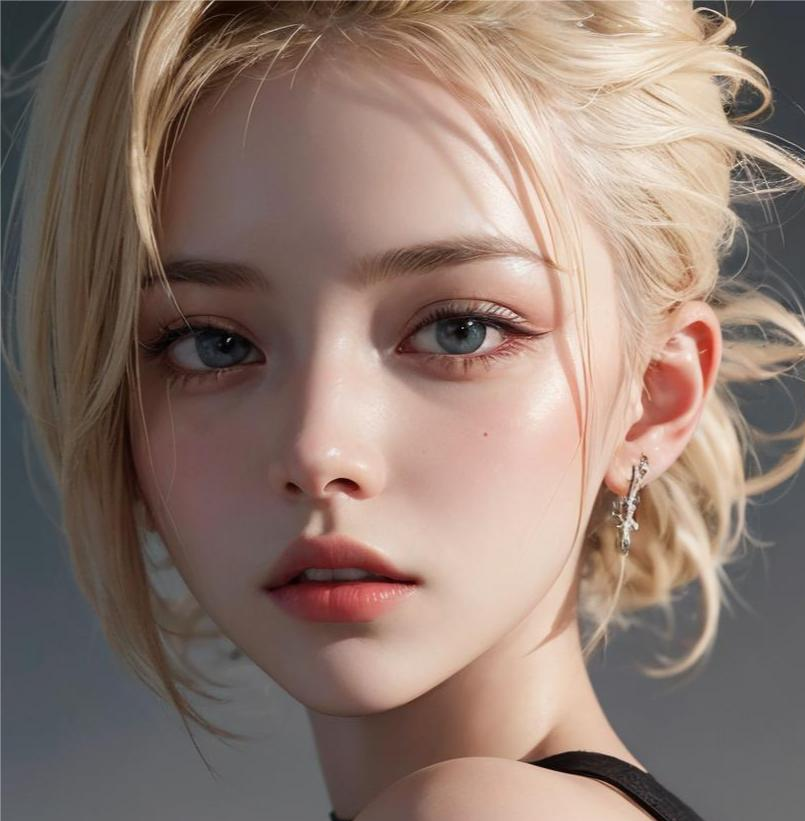

In [ ]:
import cv2
images_path = '/content/drive/MyDrive/CeleAHQ_subset_200/'
image = cv2.imread('/content/1256530.jpg' )

faces = crop_face_to_celebHQ(image)
for face in faces:
    cv2_imshow(face)

## 以下MI修改Le的代码后的代码

In [ ]:
import cv2
import mediapipe as mp
import numpy as np



def detect_face_old(image_path, confidence_level = 0.7):
    # 初始化mediapipe人脸检测模型
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=3, min_detection_confidence=confidence_level)

    # 读取输入的图像
    image = cv2.imread(image_path)
    if image is None:
        print("无法读取图像，请检查图像路径！")
        return None, None

    # 转换图像为RGB格式（MediaPipe人脸检测器要求输入为RGB图像）
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 使用MediaPipe进行人脸检测
    results = face_mesh.process(image_rgb)

    # 检测是否成功
    if results.multi_face_landmarks:
        # 获取每张人脸的关键点，并转换为NumPy数组
        face_landmarks_list = [np.array([[lm.x, lm.y] for lm in face_landmarks.landmark]) for face_landmarks in results.multi_face_landmarks]

        # 计算每张人脸的面积，并选择最大的一个
        max_face_area = 0
        max_face_index = 0
        for i, landmarks_np in enumerate(face_landmarks_list):
            # 计算凸包
            scaled_landmarks = landmarks_np * np.array([image.shape[1], image.shape[0]])
            hull = cv2.convexHull(scaled_landmarks.astype(np.int32))
            # 计算凸包面积
            face_area = cv2.contourArea(hull)
            # 更新最大面积和索引
            if face_area > max_face_area:
                max_face_area = face_area
                max_face_index = i

        # 获取最大的人脸关键点
        largest_face_landmarks_np = face_landmarks_list[max_face_index]

        # 返回最大的人脸关键点及其面积
        return largest_face_landmarks_np, max_face_area
    else:
        print("未检测到人脸！")
        return None, None


def align_face_old(image, face_landmarks_np):
    # 计算人脸中心
    center_x = np.mean(face_landmarks_np[:, 0])
    center_y = np.mean(face_landmarks_np[:, 1])
    center = (int(center_x), int(center_y))

    # 计算两眼之间的角度
    left_eye = face_landmarks_np[36]
    right_eye = face_landmarks_np[45]
    angle = np.degrees(np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]))

    # 计算旋转矩阵
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)

    # 对图像进行旋转
    aligned_face = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

    return aligned_face

最大人脸的关键点：468
最大人脸的面积：327239.0


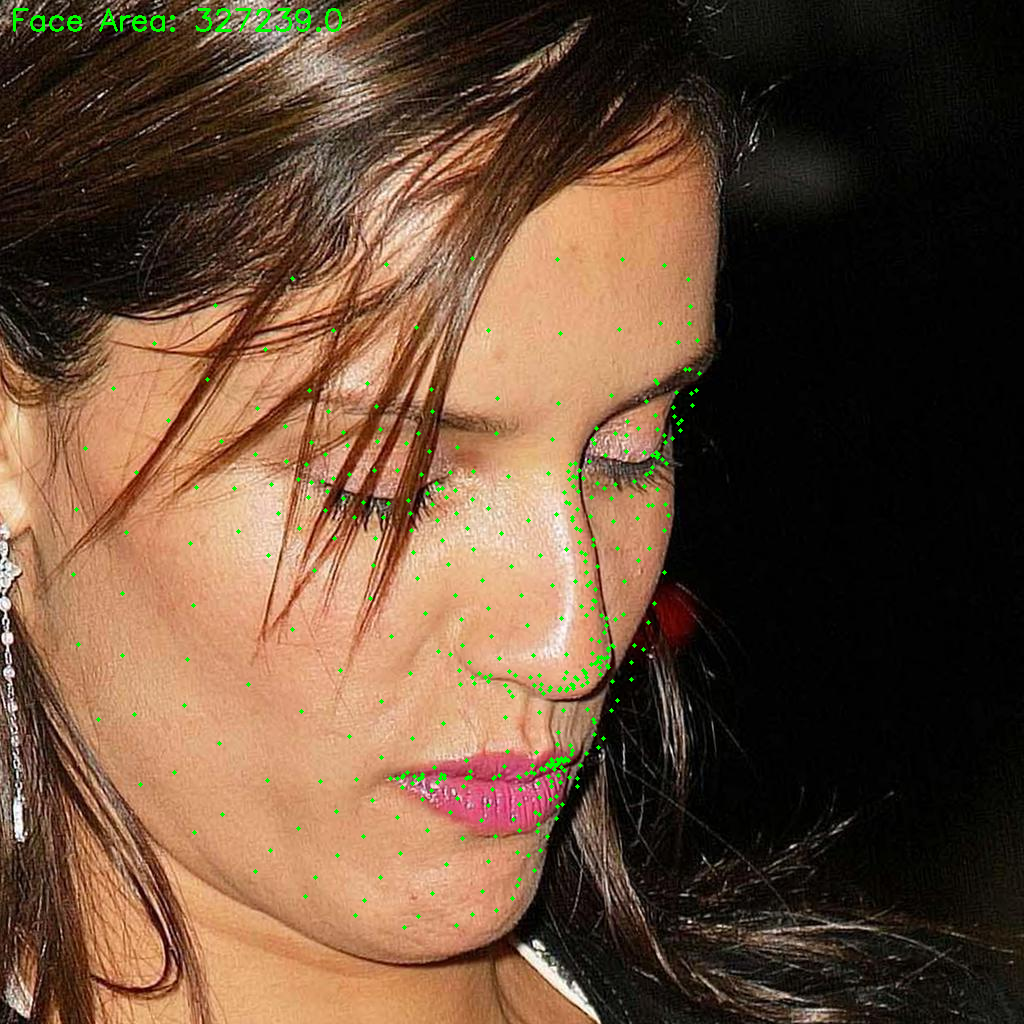

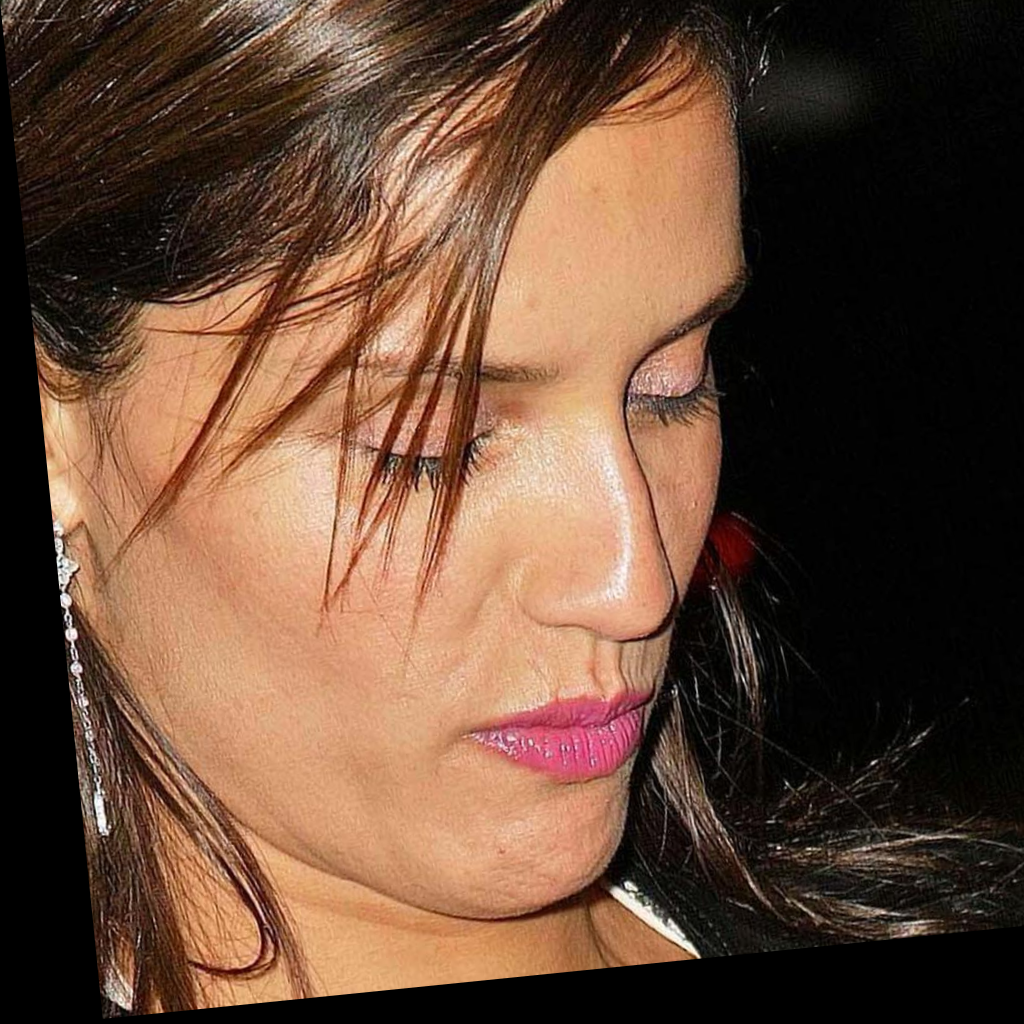

In [ ]:
from google.colab.patches import cv2_imshow
image_path = '/content/000004.jpg.jpg'  # 输入图像路径

# 检测人脸并获取最大人脸的关键点及其面积
face_landmarks_np, max_face_area = detect_face(image_path)

print(f"最大人脸的关键点：{len(face_landmarks_np)}")
print(f"最大人脸的面积：{max_face_area}")

if face_landmarks_np is not None:
    # 读取原始图像
    image = cv2.imread(image_path)

    # 对齐人脸
    aligned_face = align_face(image, face_landmarks_np)  # 注意这里我们只取第一个人脸的关键点

    for landmark in face_landmarks_np:
        x, y = landmark
        cv2.circle(image, (int(x * image.shape[1]), int(y * image.shape[0])), 2, (0, 255, 0), -1)
    cv2.putText(image, f"Face Area: {max_face_area}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # 显示原始图像和对齐后的人脸图像
    cv2_imshow(image)
    cv2_imshow(aligned_face)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

In [ ]:
len(face_landmarks_np)

468